# Explore audio data

In [1]:
DATASET_ID = "git_repos"

In [2]:
import pdb
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import pandas as pd
import librosa
from datetime import datetime
import json
import numpy as np
from pathlib2 import Path

In [3]:
import avgn

In [4]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [5]:
DATA_DIR

WindowsPath('C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data')

In [6]:
DATASET_ID = "git_repos"

In [7]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [8]:
#Defining Path to Raw Dataset
RAW_DATASET_LOC = DATA_DIR/"raw"/"magpie"/"individuals"
RAW_DATASET_LOC

WindowsPath('C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals')

In [9]:
#array of all WAV files
WAVLIST = np.array(list((RAW_DATASET_LOC).expanduser().glob('*/*.wav')))
WAVLIST[0], len(WAVLIST)

(WindowsPath('C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals/BWYa_F_MGGY/BWY MGGY Call Combo 1 290719 PM.wav'),
 153)

In [10]:
#creating array containing just stem of WAVLIST arrays (i.e. just the file name)
wav_stems = np.array([i.stem for i in WAVLIST])
wav_stems[0]

'BWY MGGY Call Combo 1 290719 PM'

In [11]:
#grab an array of all textgrid files 
TGLIST = np.array(list((RAW_DATASET_LOC).expanduser().glob('*/*.TextGrid')))
TGLIST = np.array([i for i in TGLIST if i.stem[0] != '.'])
TGLIST[0], len(TGLIST)

(WindowsPath('C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals/BWYa_F_MGGY/BWY MGGY Call Combo 1 290719 PM.TextGrid'),
 153)

In [12]:
# create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=400,
    mel_upper_edge_hertz=15000,
    butter_lowcut = 400,
    butter_highcut = 15000,
    ref_level_db = 20,
    min_level_db = -30,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

In [13]:
# create a dataset object, which
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:  1.1min finished


getting unique individuals:   0%|          | 0/152 [00:00<?, ?it/s]

In [14]:
# to make sure everything loaded correctly, lets look at a sample JSON
print(json.dumps(dataset.sample_json, indent=4, default=str)[0:15000] + '...')

{
    "filename": "BWY MGGY Call Combo 1 290719 PM",
    "samplerate_hz": 44100,
    "sex": "F",
    "group": "BWYa",
    "location": "CRAWLEY",
    "wav_loc": "C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals/BWYa_F_MGGY/BWY MGGY Call Combo 1 290719 PM.WAV",
    "length_s": 2.1197732426303855,
    "species": "Gymnorhina tibicen dorsalis",
    "common_name": "Western Australian magpie",
    "indvs": {
        "MGGY": {
            "call": {
                "labels": [
                    "DSSHDS",
                    "DSSHDS",
                    "DSSHDS",
                    "SHSHLH",
                    "SHSHLH",
                    "SHSHLH"
                ],
                "start_times": [
                    0.753604333,
                    0.753604333,
                    0.753604333,
                    0.932017365,
                    0.932017365,
                    0.932017365
                ],
                "end_times": [
                    0.

## Explore Data

In [15]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
from praatio import tgio
from datetime import datetime
import seaborn as sns

In [16]:
from avgn.signalprocessing import spectrogramming as sg

In [17]:
from tqdm.auto import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.visualization.spectrogram import visualize_spec, plot_spec
from avgn.utils.hparams import HParams 
from avgn.signalprocessing.filtering import butter_bandpass_filter

In [18]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [19]:
##import pickle
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / 'walsh_magpie_combined_dataframe.pickle')
seg_df[:3]

,New_ID,indv,gro,location,sex,wavloc,filename,seg_label,seg_start,seg_end,...,call_start,call_end,combi_label,combi_start,combi_end,call_unique_num,seg_pos_call,combi_unique_num,seg_pos_combi,call_pos_combi
0,0,MGGY,BWYa,CRAWLEY,F,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,DS,0.753604,0.776773,...,0.753604,0.92116,DSSHDS SHSHLH,0.753604,1.36713,0,0,0,0,0
1,1,MGGY,BWYa,CRAWLEY,F,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,SH,0.786865,0.835165,...,0.753604,0.92116,DSSHDS SHSHLH,0.753604,1.36713,0,1,0,1,0
2,2,MGGY,BWYa,CRAWLEY,F,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,DS,0.855941,0.921160,...,0.753604,0.92116,DSSHDS SHSHLH,0.753604,1.36713,0,2,0,2,0


In [20]:
#how many unique individuals?
len(np.unique(seg_df.indv))

23

In [21]:
#How many segs?
len(seg_df)

1647

In [27]:
phrase_df = seg_df

In [28]:
def get_phrases(tg, WAVLIST, wav_stems):  
    
    wav_file_loc = (
        DATA_DIR
        /"raw"
        /"magpie"
        /"individuals"
        / tg.parent.stem
        / (tg.stem + ".WAV")
    )
    
    phrase_df = pd.DataFrame(
        columns=[
            "indv",
            "filename",
            "wavloc",
            "tgloc",
            "note_num",
            "note_start",
            "vocdata",
            "rate",
            "voc_len",
        ]
    )
    
    indv = tg.parent.stem[:10]
    filen = tg.stem[:30]
    wf = wf = wav_file_loc
    rate, data = load_wav(wf)
    textgrid = tgio.openTextgrid(fnFullPath=tg)
    tier = textgrid.tierDict['Note'].entryList
    for inti, interval in enumerate(tier):
        phrasedata = data[int(interval.start*rate):int(interval.end*rate)]
        
        
        phrase_df.loc[len(phrase_df)] = [
            indv, filen, wf, tg, inti, interval.start, phrasedata, rate, len(phrasedata)/rate
        ]
    return phrase_df


In [30]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    phrase_df = parallel(
        delayed(get_phrases)(tg, WAVLIST, wav_stems)
        for tg in tqdm(TGLIST)
    )
phrase_df = pd.concat(phrase_df)

  0%|          | 0/153 [00:00<?, ?it/s]

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done  75 out of 153 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=24)]: Done 153 out of 153 | elapsed:    1.5s finished


In [31]:
phrase_df[:3]

,indv,filename,wavloc,tgloc,note_num,note_start,vocdata,rate,voc_len
0,BWYa_F_MGG,BWY MGGY Call Combo 1 290719 P,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,0,0.753604,"[-0.002166748, -0.0011901855, -0.00033569336, ...",44100,0.023175
1,BWYa_F_MGG,BWY MGGY Call Combo 1 290719 P,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,1,0.786865,"[0.005340576, 0.0077209473, 0.008575439, 0.007...",44100,0.048299
2,BWYa_F_MGG,BWY MGGY Call Combo 1 290719 P,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,C:\Users\slwal\anaconda3\envs\PY36\avgn_paper-...,2,0.855941,"[0.0107421875, -0.012359619, -0.031707764, -0....",44100,0.065215


C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slwal\anaconda3\envs\PY36\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

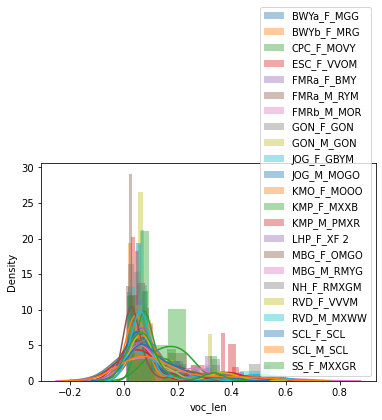

In [32]:
for indv in np.unique(phrase_df.indv):
    sns.distplot(phrase_df[phrase_df.indv==indv]["voc_len"], label=indv)
plt.legend()

In [33]:
rate = phrase_df.rate.values[0]

## Create Spectrograms

In [34]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix

In [35]:
win_length_ms = 20
hop_length_ms = 10
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=2048,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=0,
    min_level_db=-100,
    preemphasis=0.30,
    # mel scaling
    num_mel_bins=32,
    mel_lower_edge_hertz=0,
    mel_upper_edge_hertz=22000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=40,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

882.0
441.0


In [36]:
print(rate)

44100


In [37]:
print(win_length_ms)

20


In [38]:
print(hop_length_ms)

10


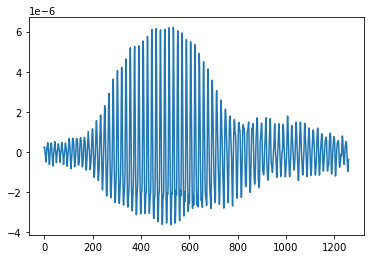

In [39]:
audio = int16_to_float32(phrase_df.vocdata.values[4])
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate)

0


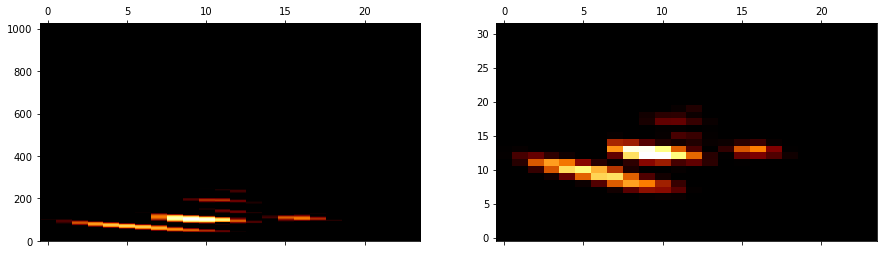

1


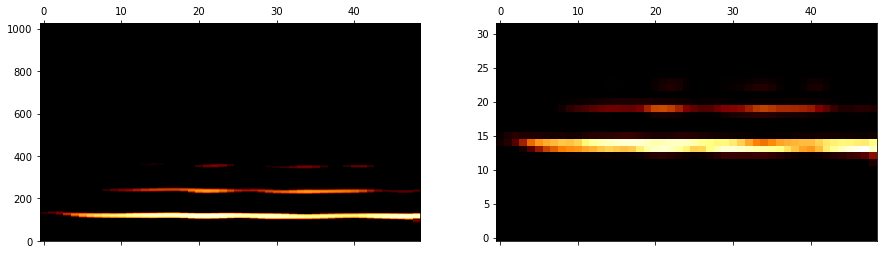

2


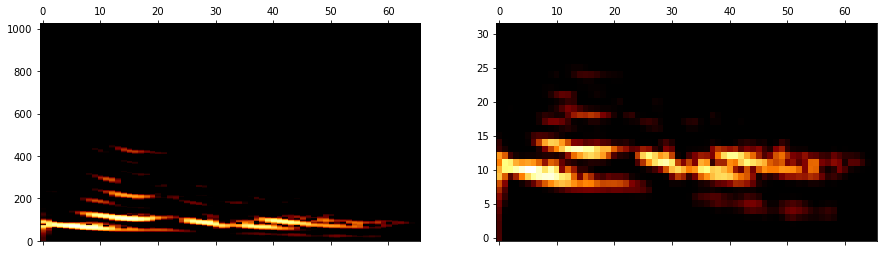

3


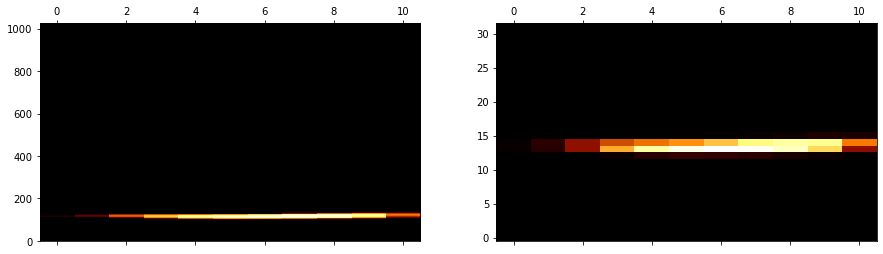

4


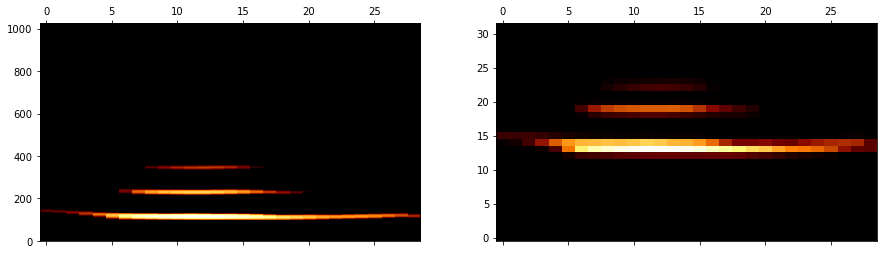

5


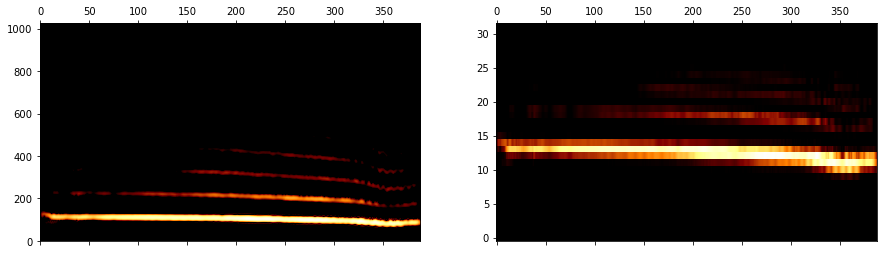

6


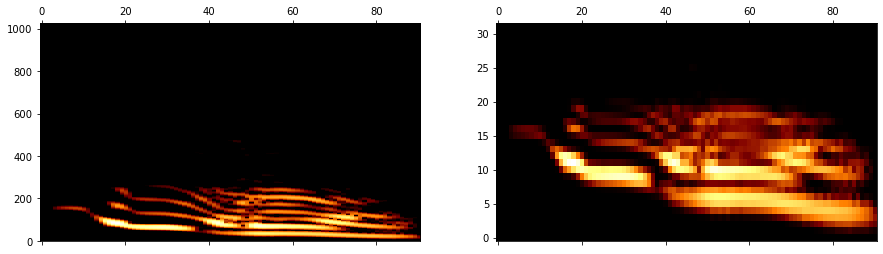

7


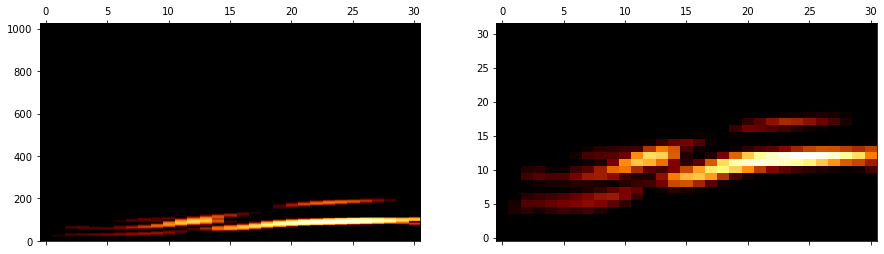

8


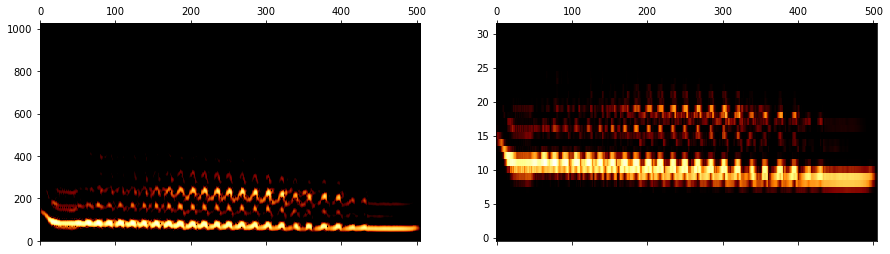

9


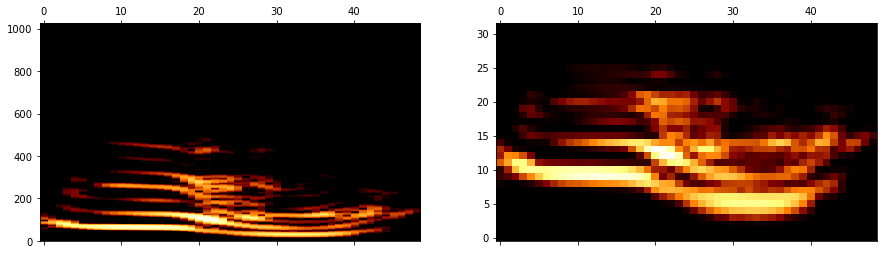

10


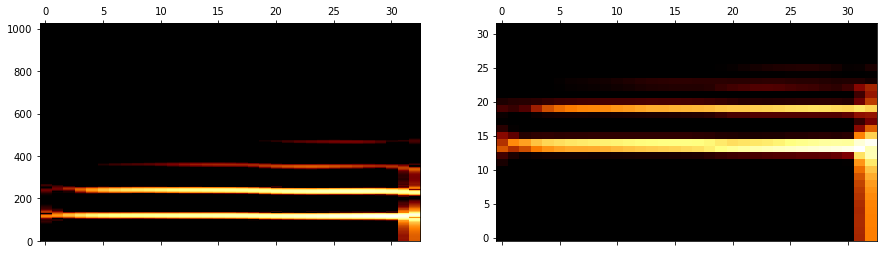

11


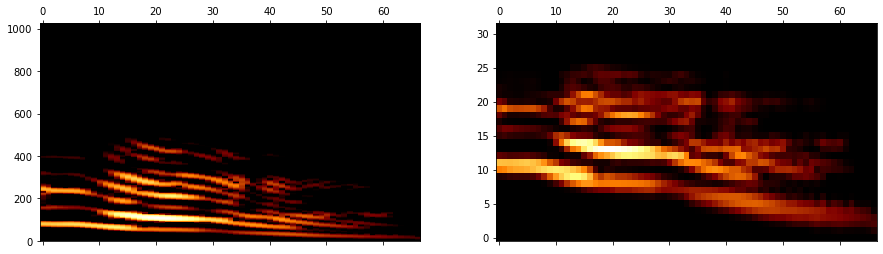

12


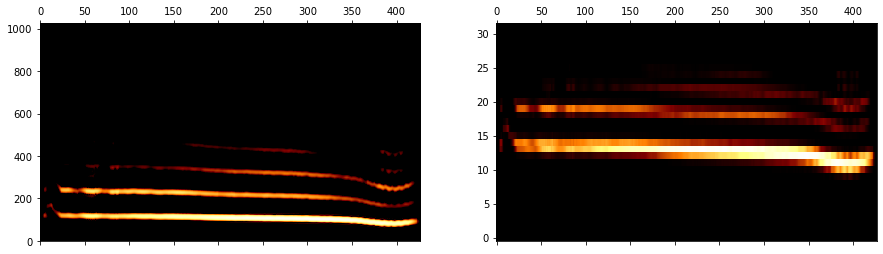

13


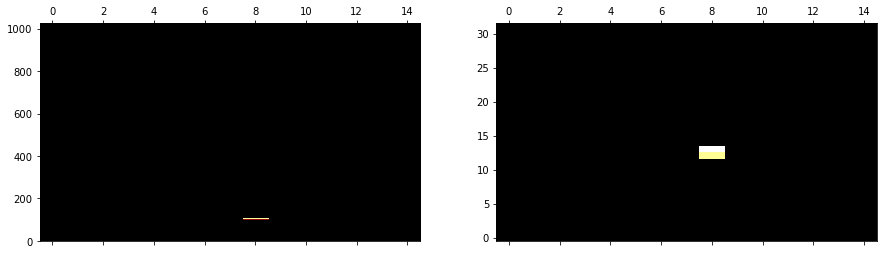

14


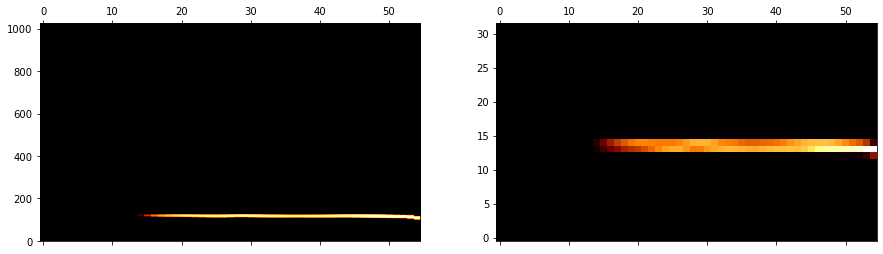

15


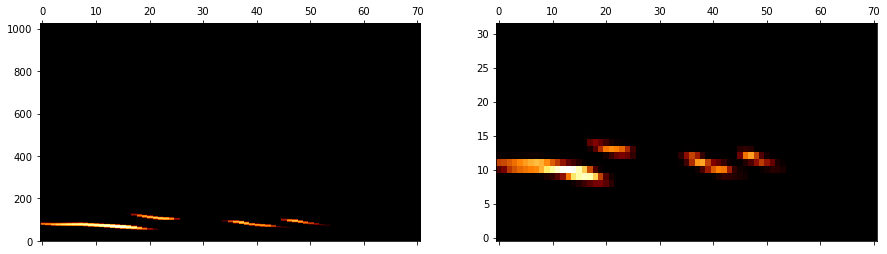

16


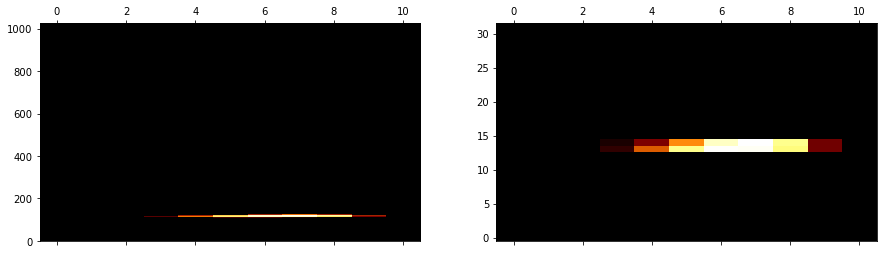

17


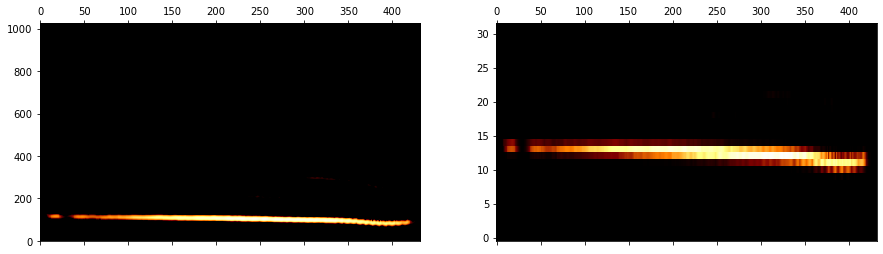

18


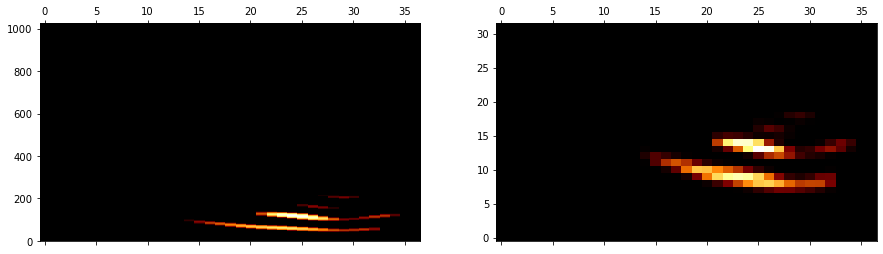

19


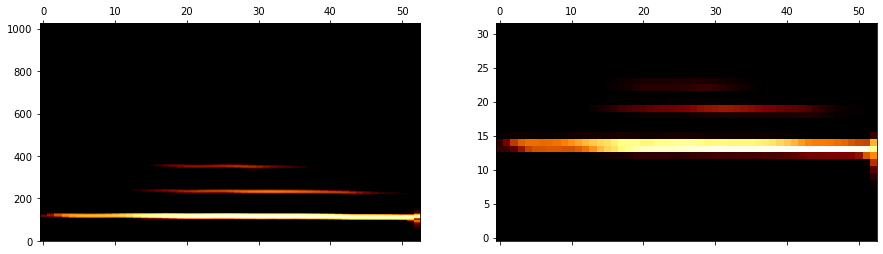

20


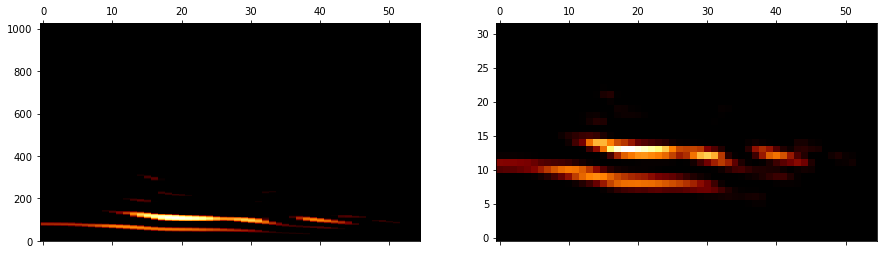

21


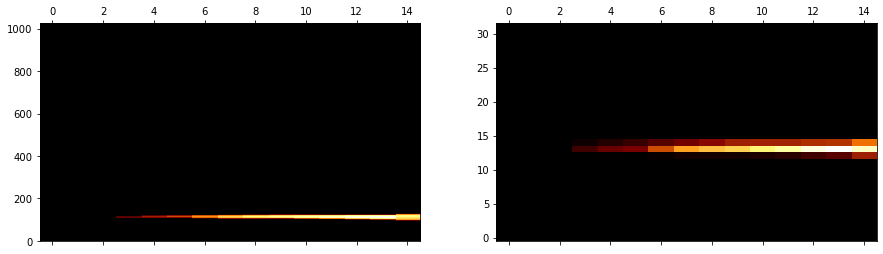

22


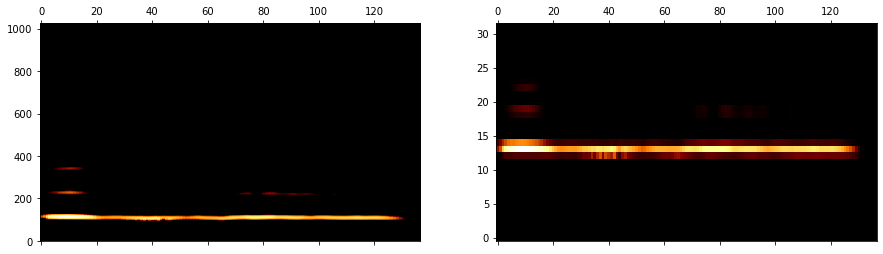

23


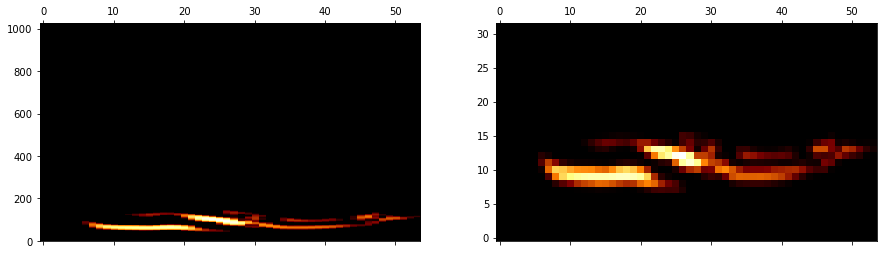

24


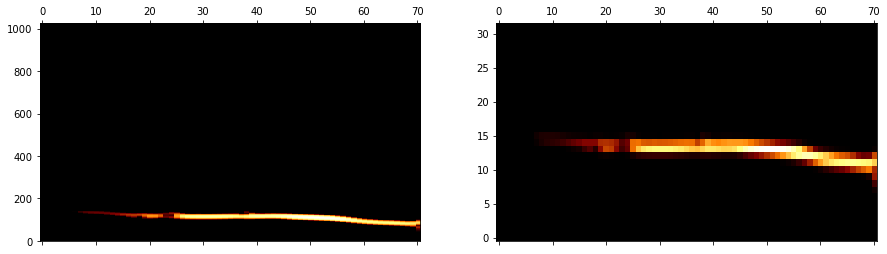

25


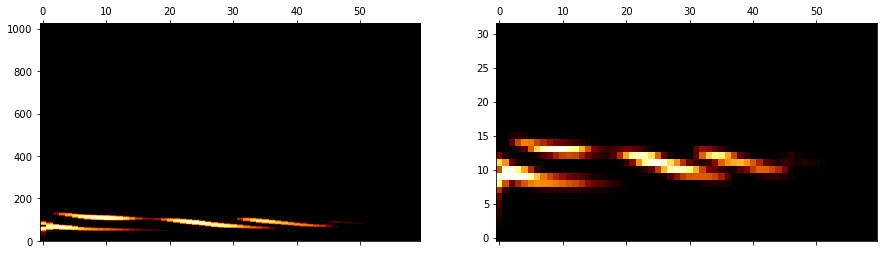

26


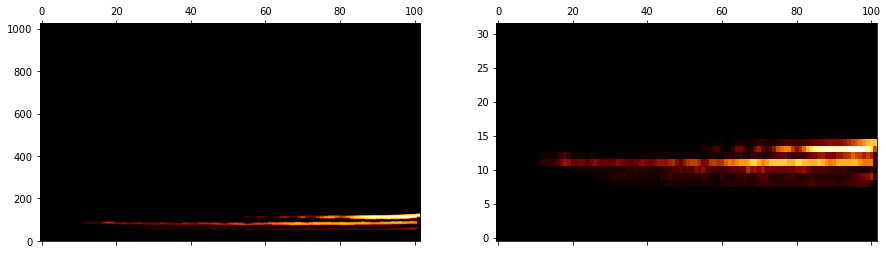

27


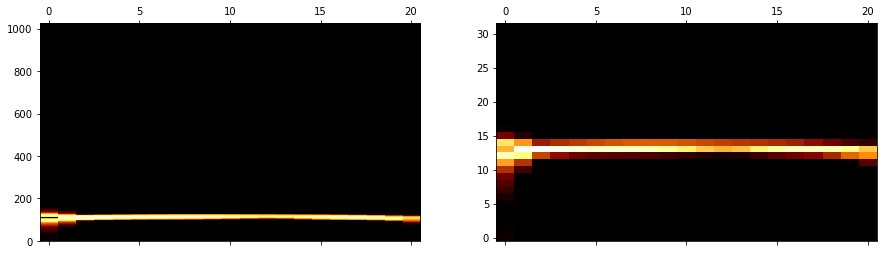

28


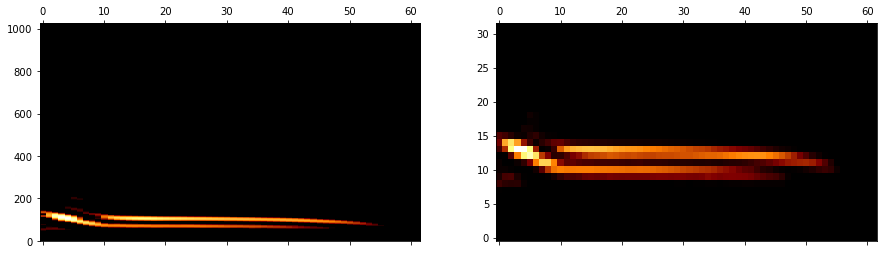

29


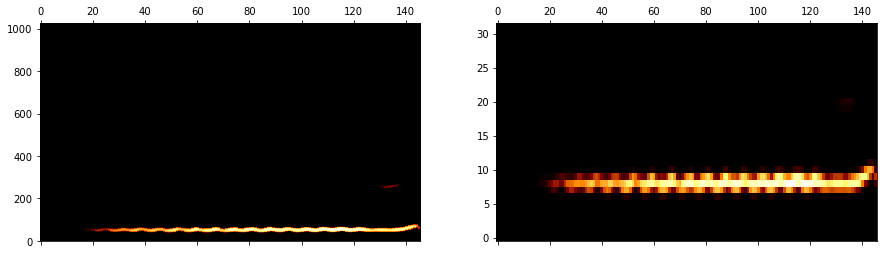

30


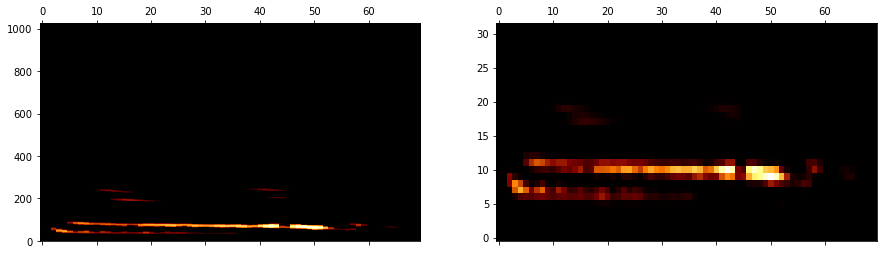

31


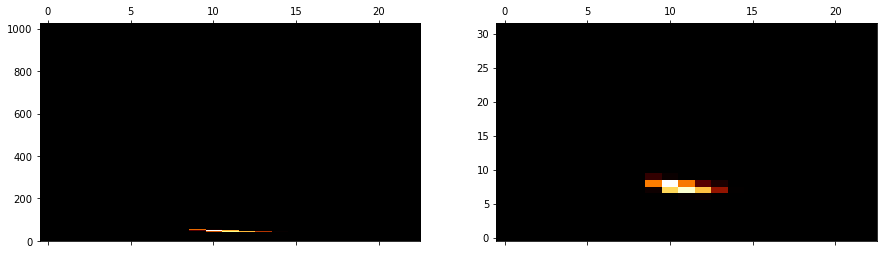

32


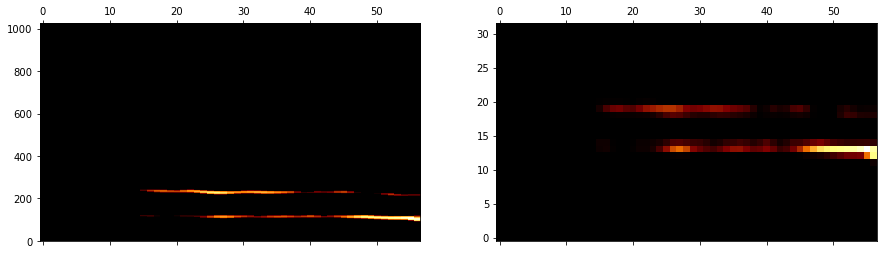

33


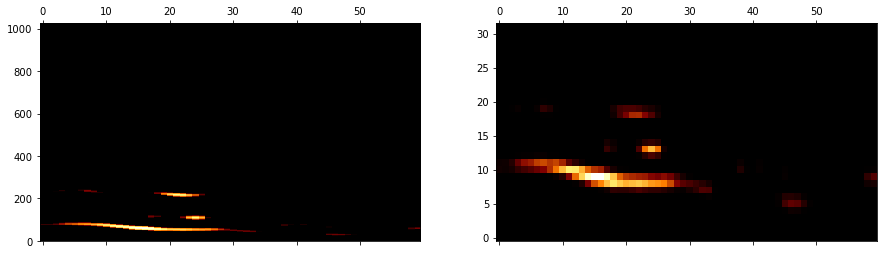

34


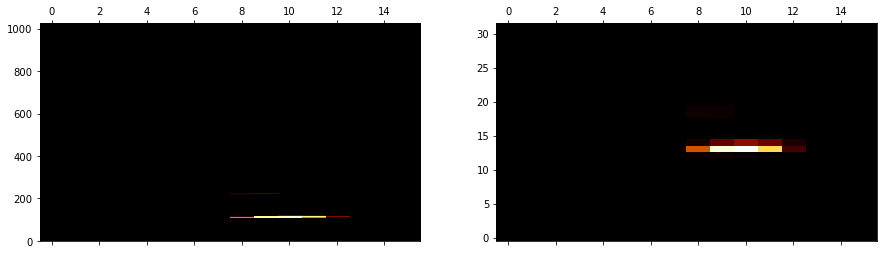

35


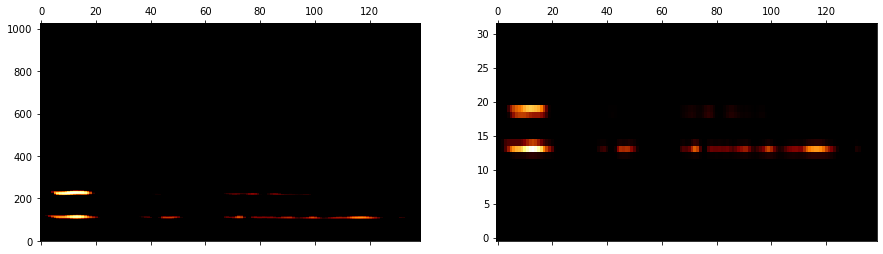

36


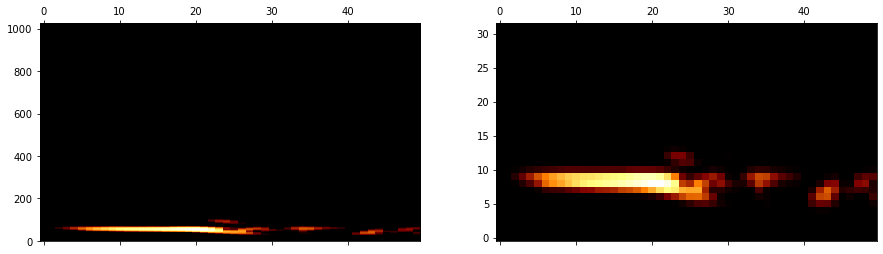

37


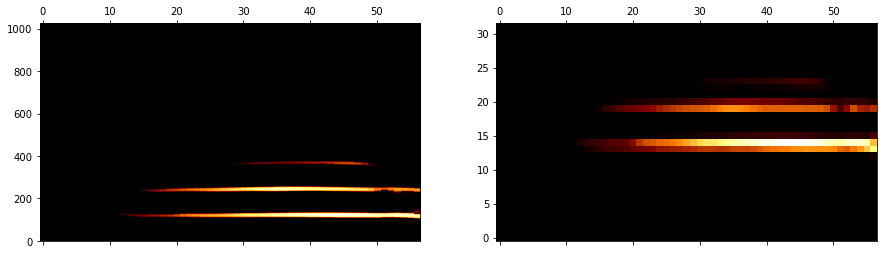

38


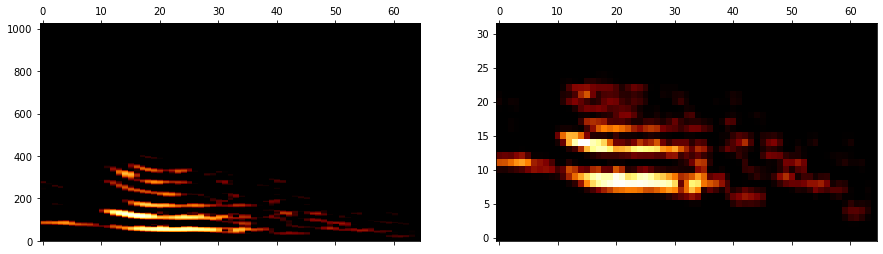

39


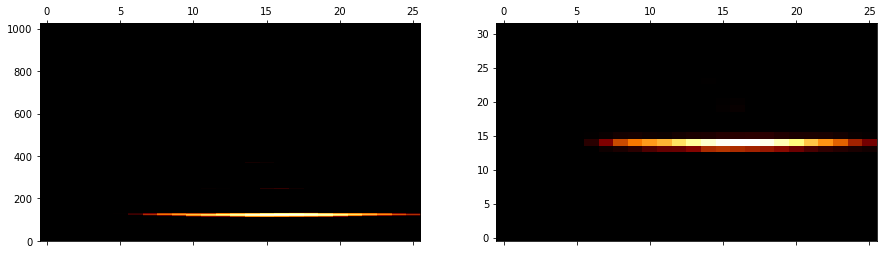

40


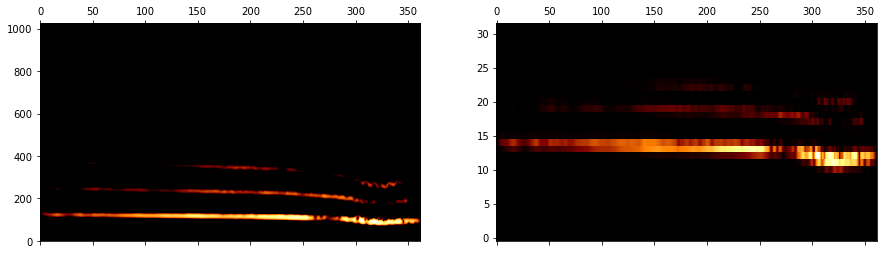

41


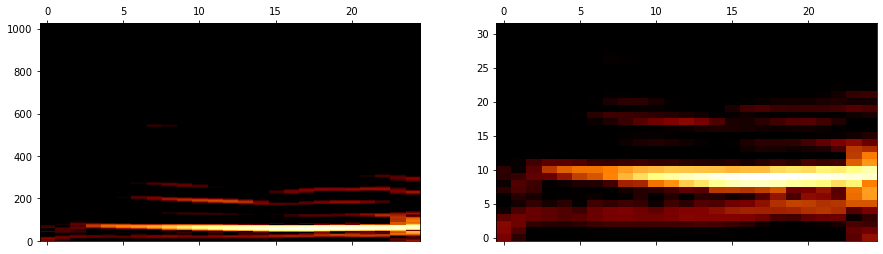

42


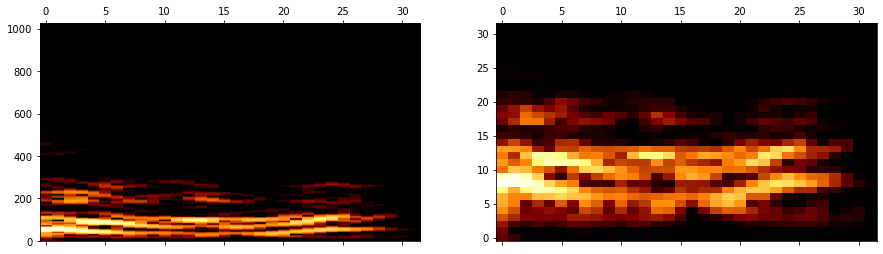

43


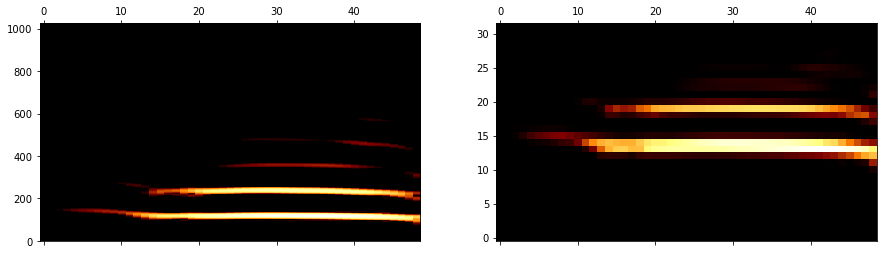

44


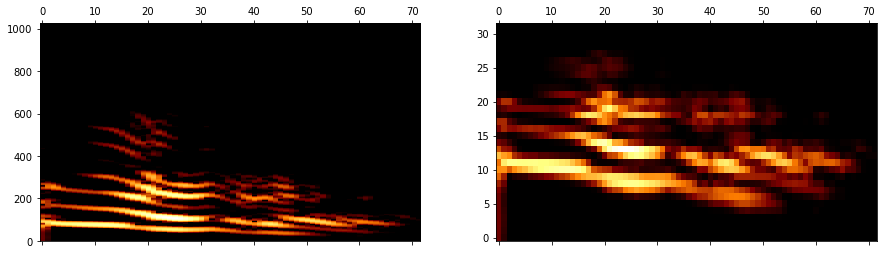

45


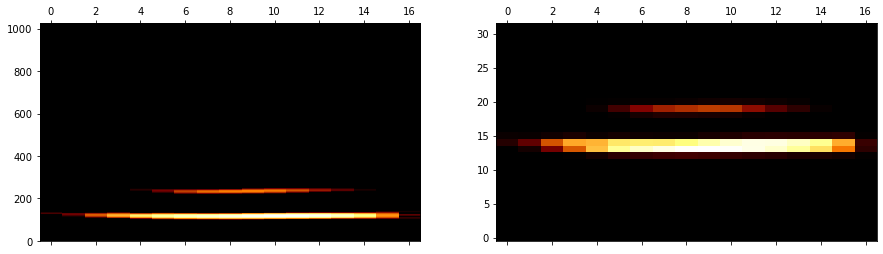

46


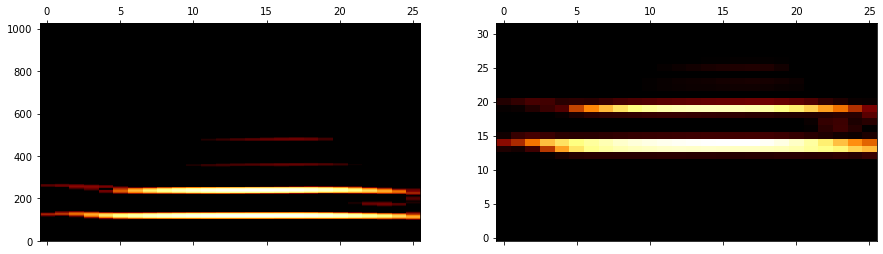

47


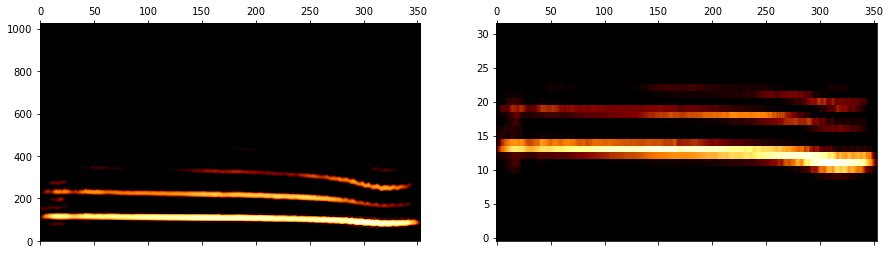

48


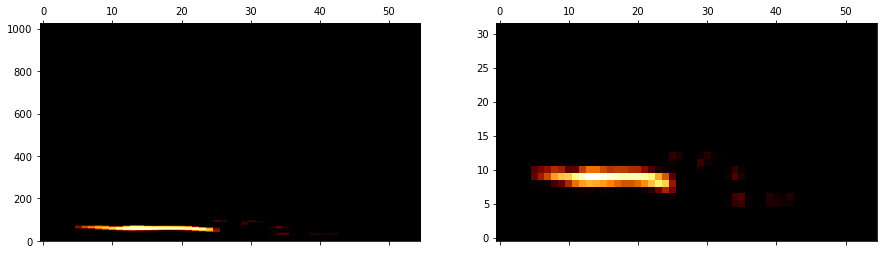

49


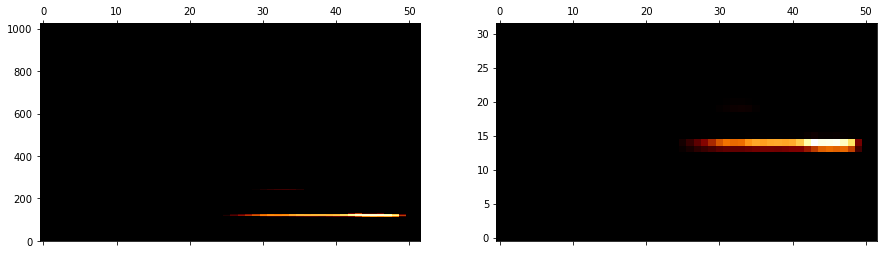

50


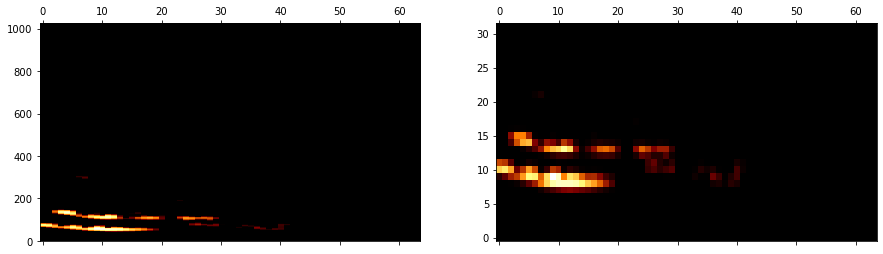

51


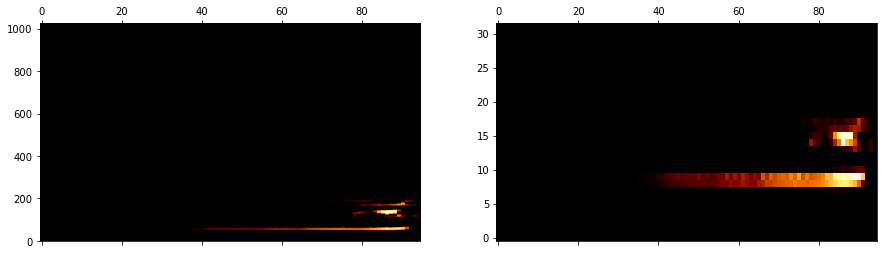

52


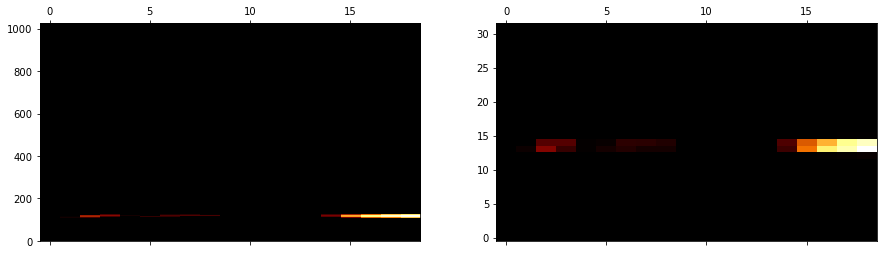

53


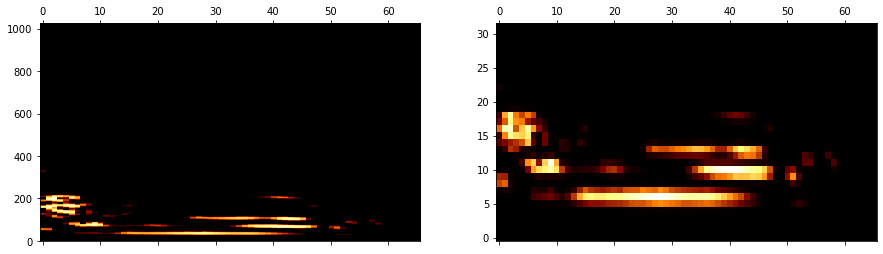

54


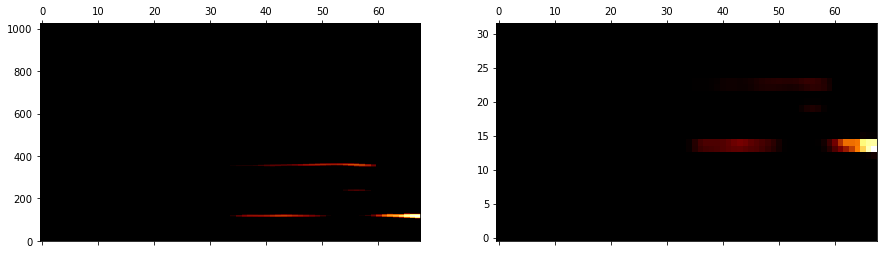

55


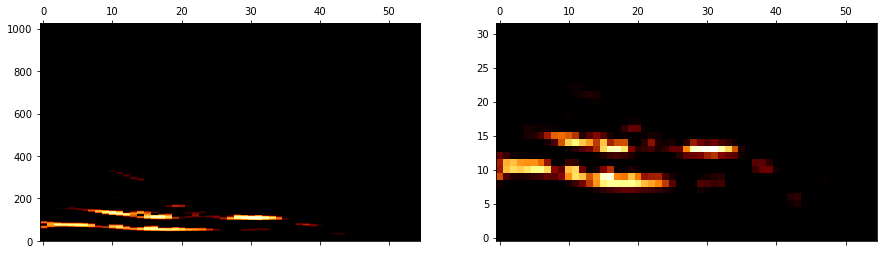

56


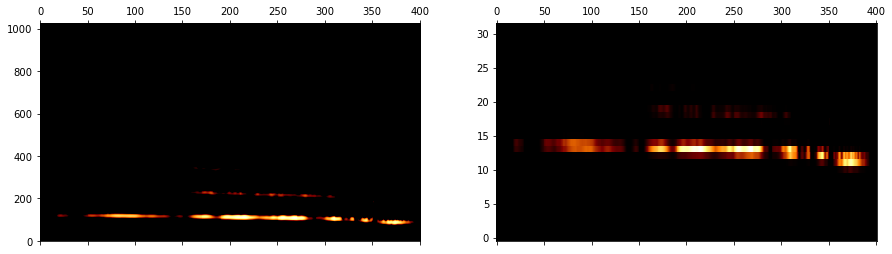

57


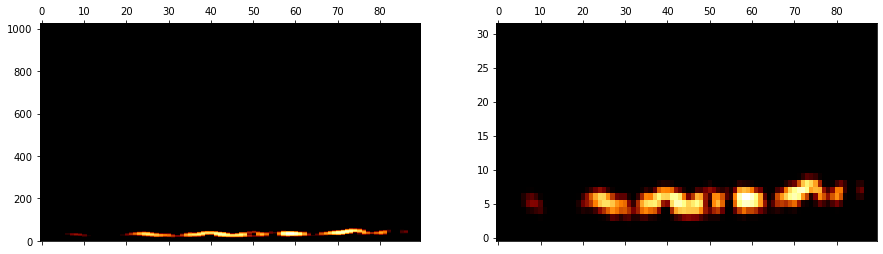

58


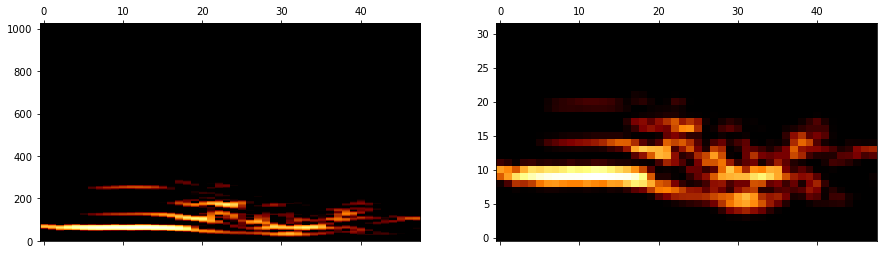

59


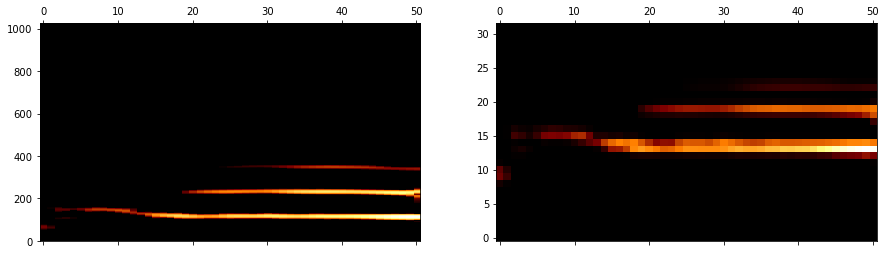

60


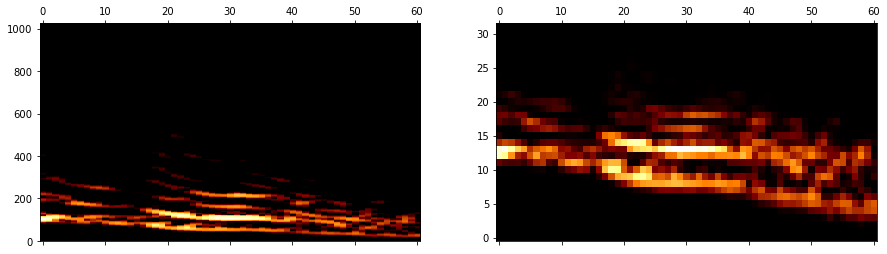

61


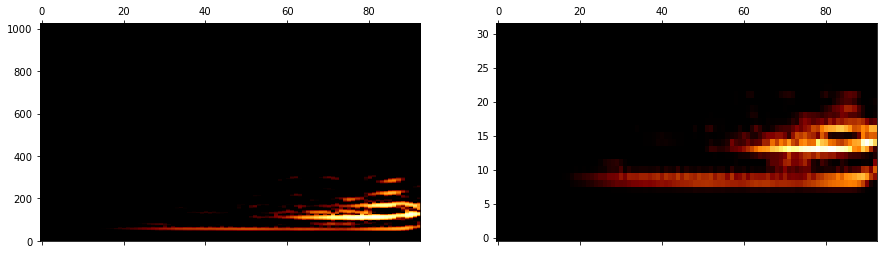

62


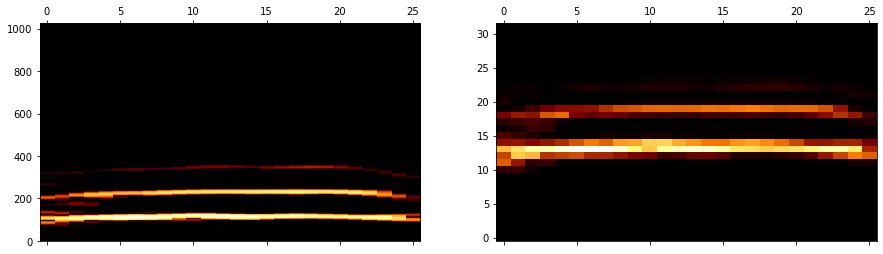

63


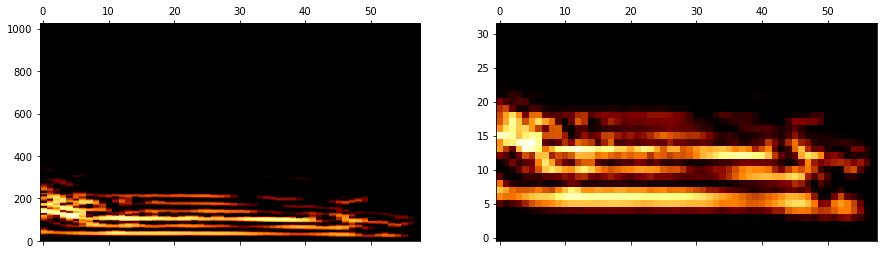

64


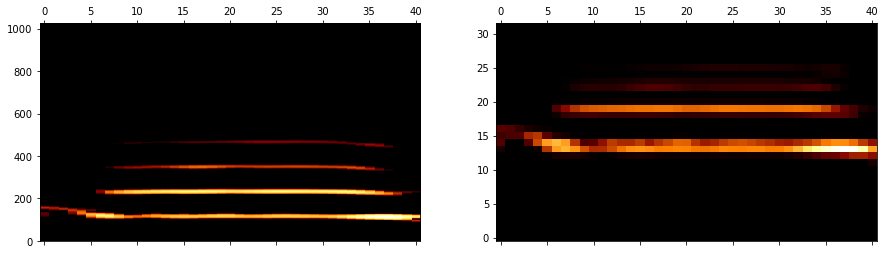

65


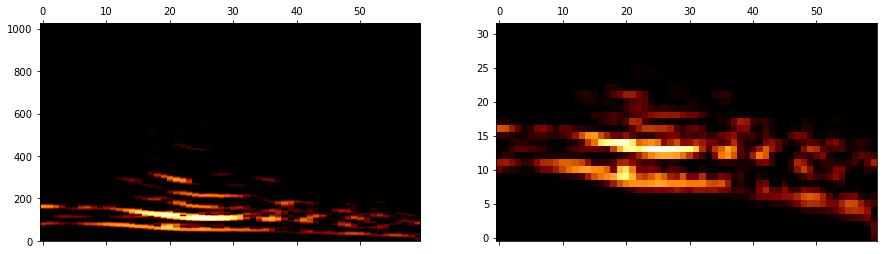

66


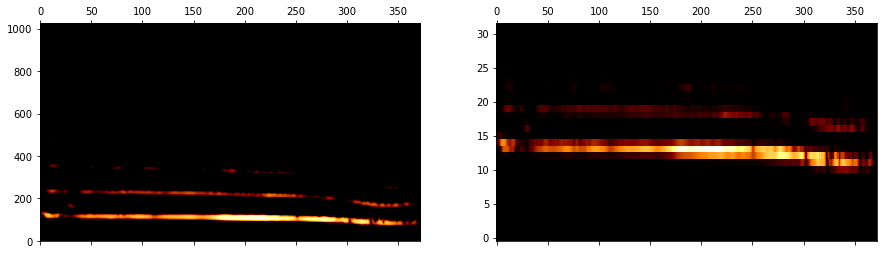

67


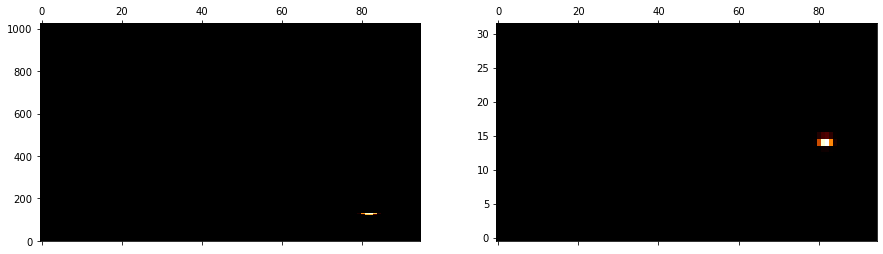

68


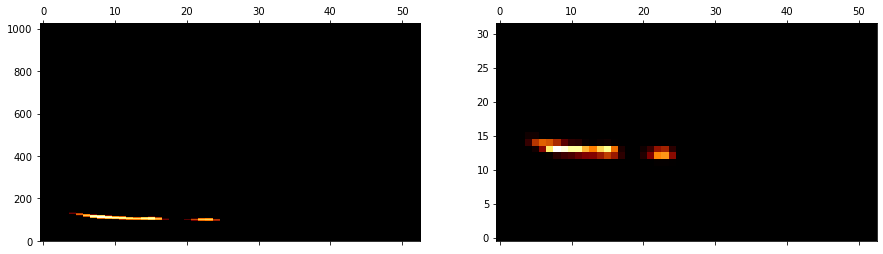

69


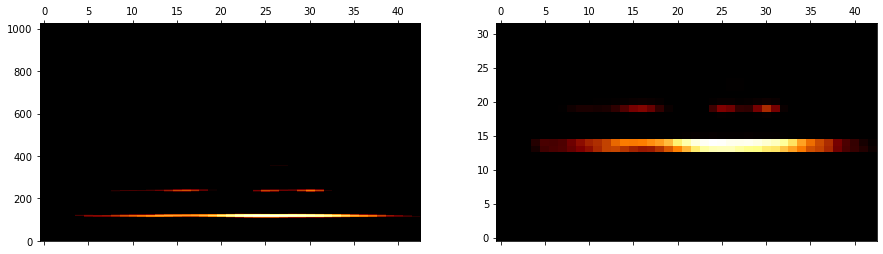

70


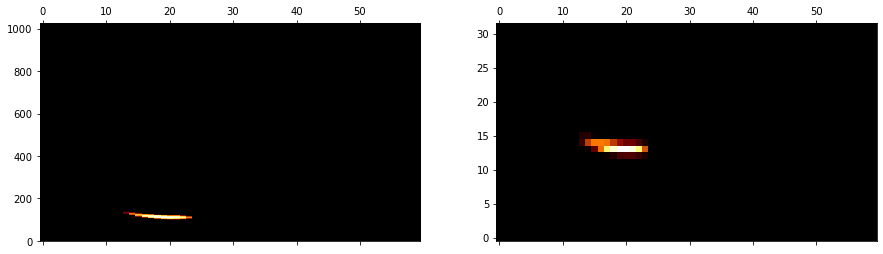

71


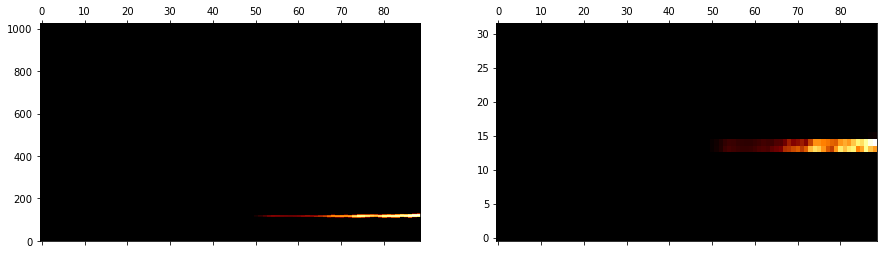

72


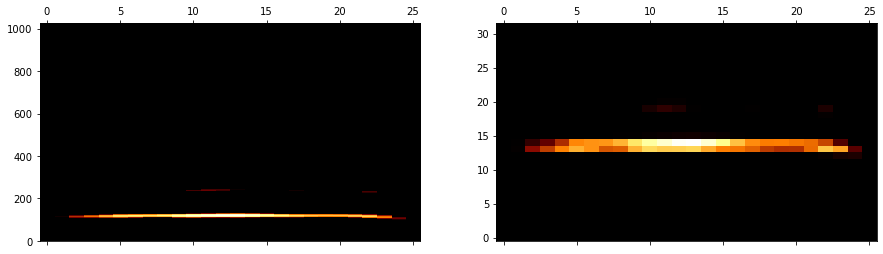

73


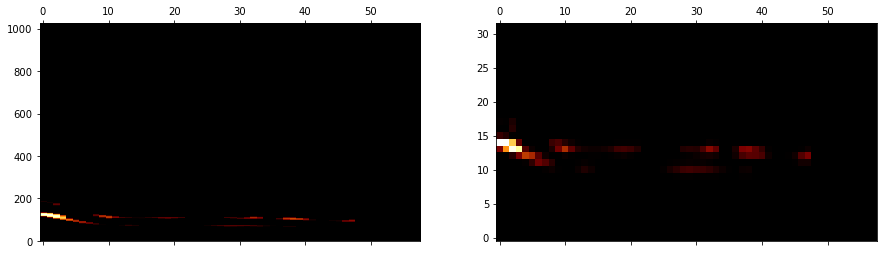

74


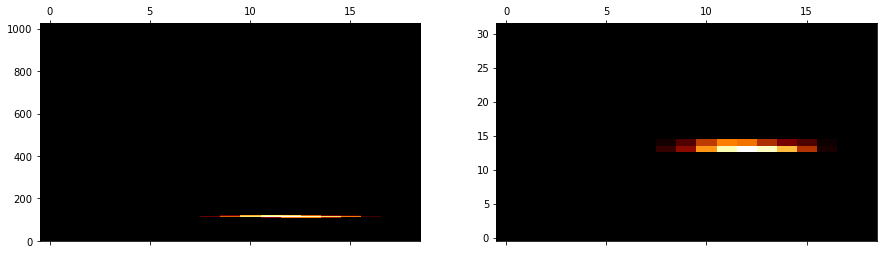

75


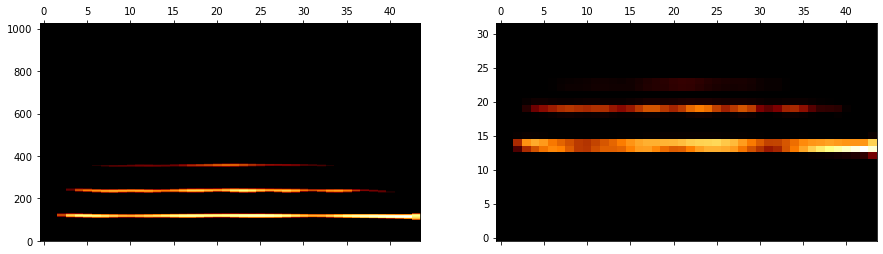

76


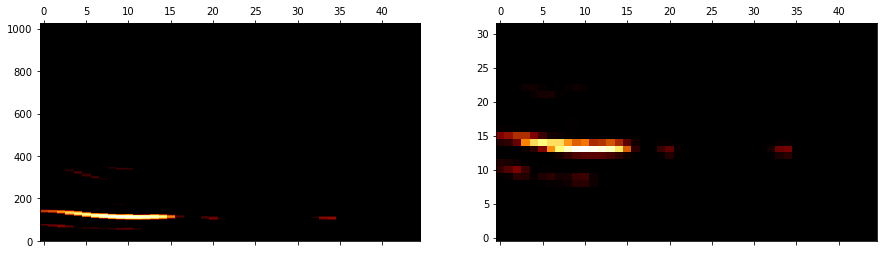

77


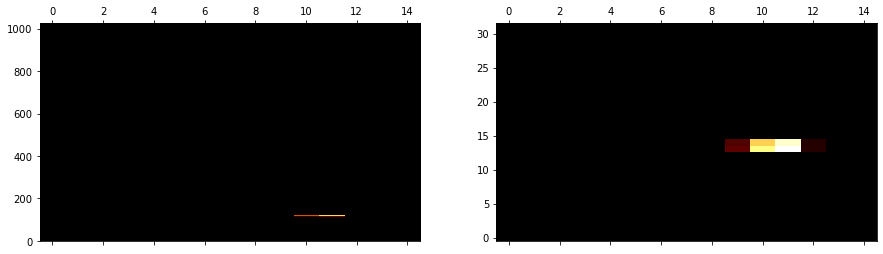

78


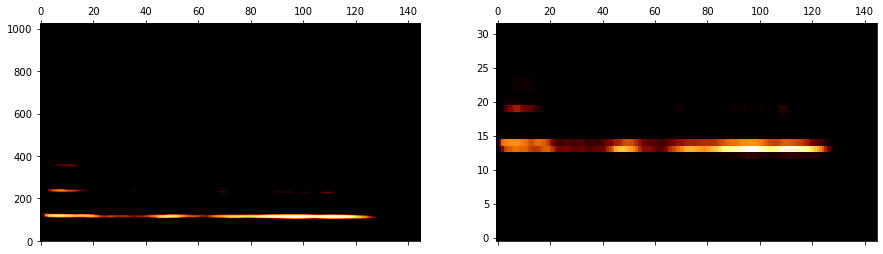

79


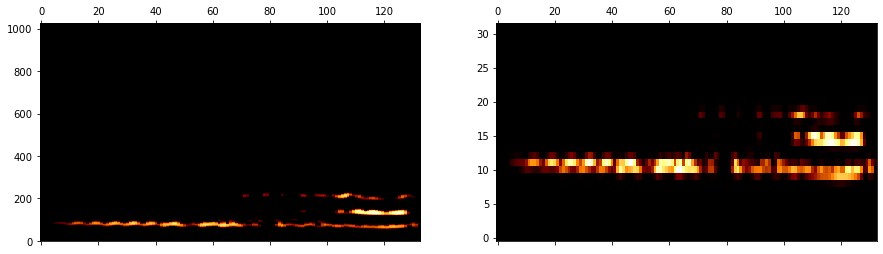

80


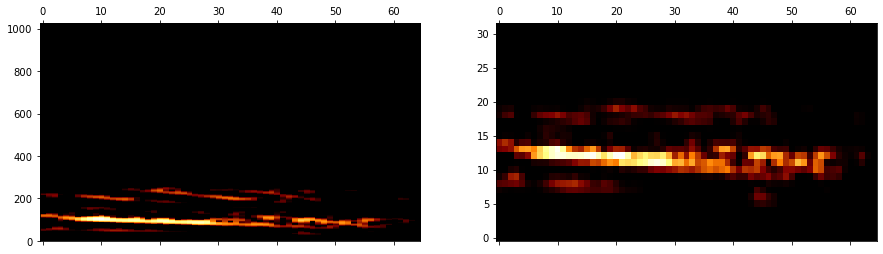

81


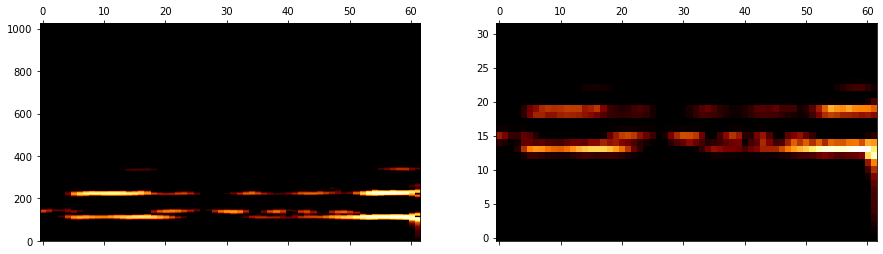

82


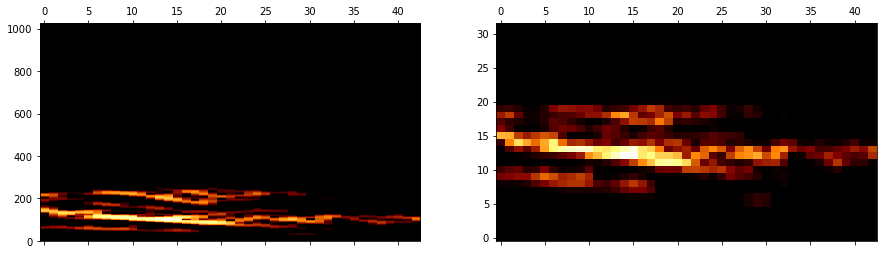

83


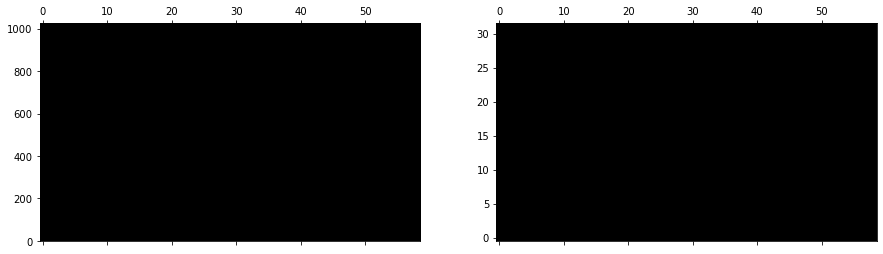

84


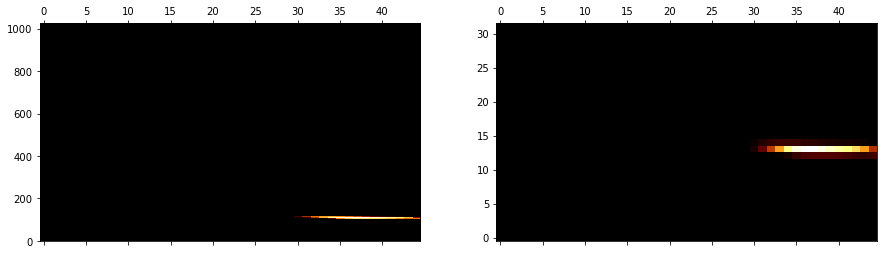

85


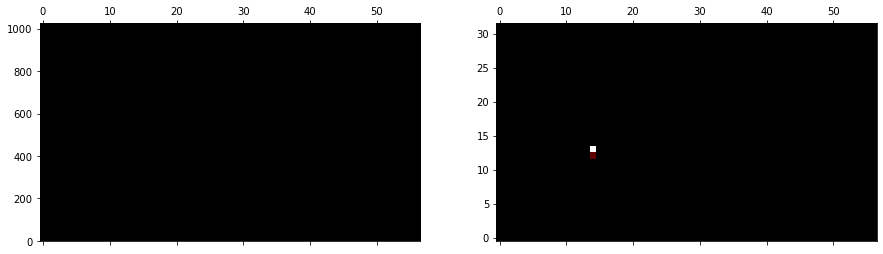

86


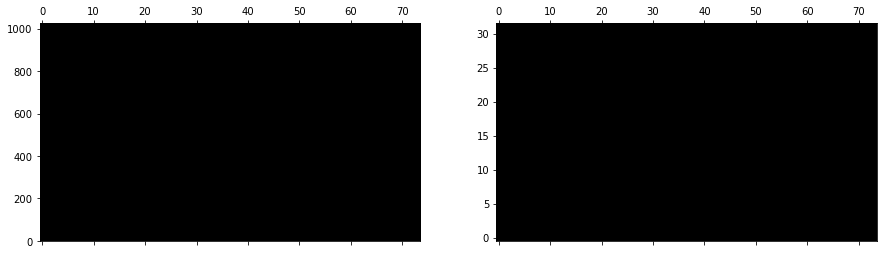

87


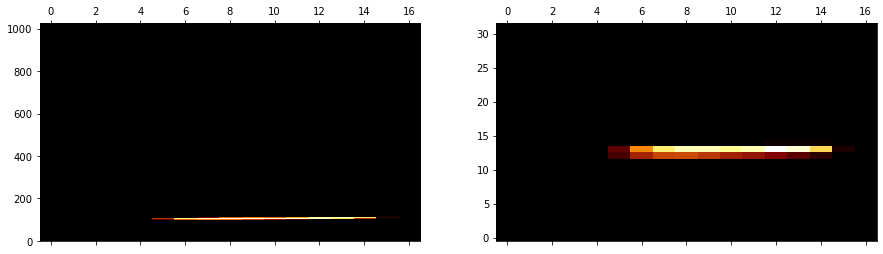

88


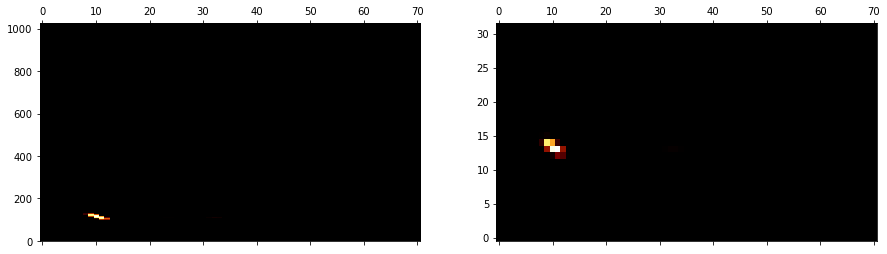

89


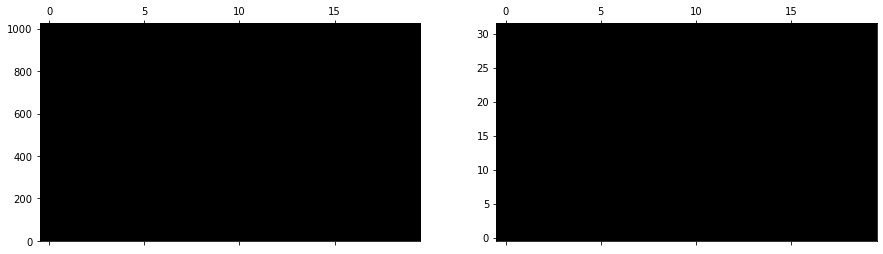

90


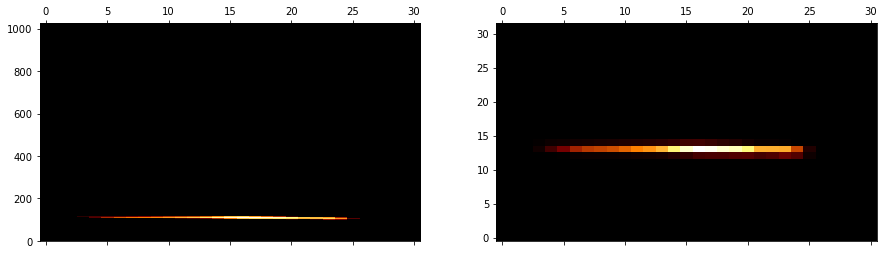

91


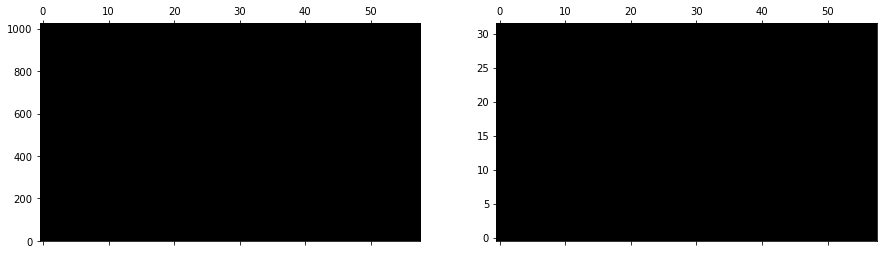

92


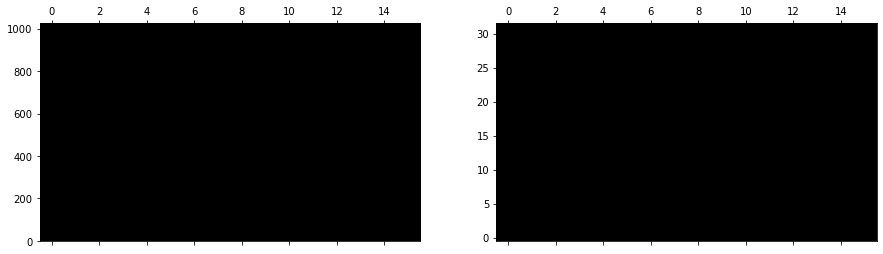

93


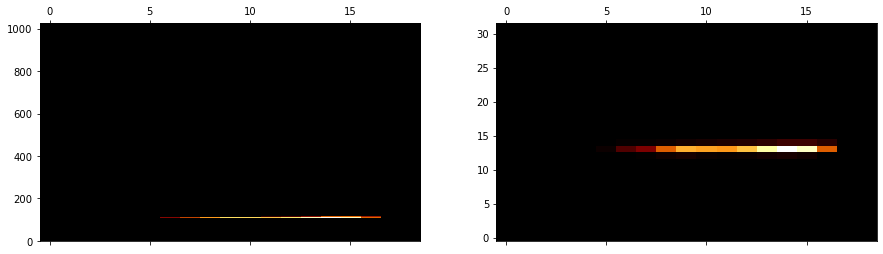

94


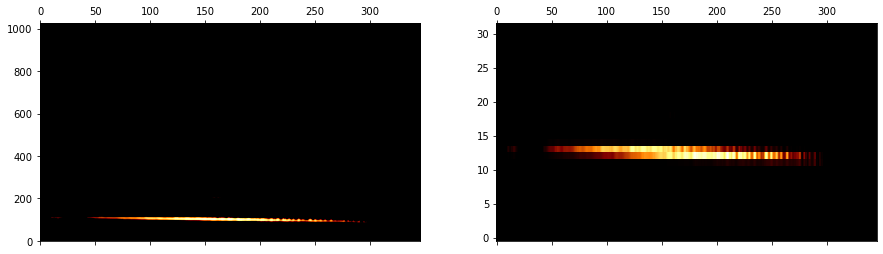

95


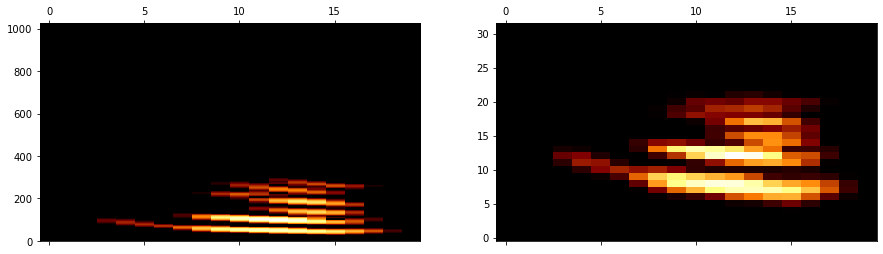

96


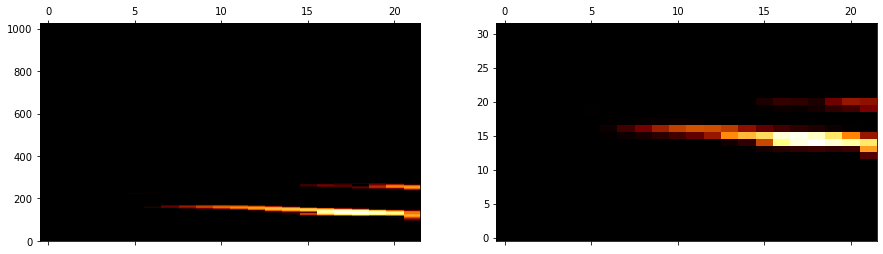

97


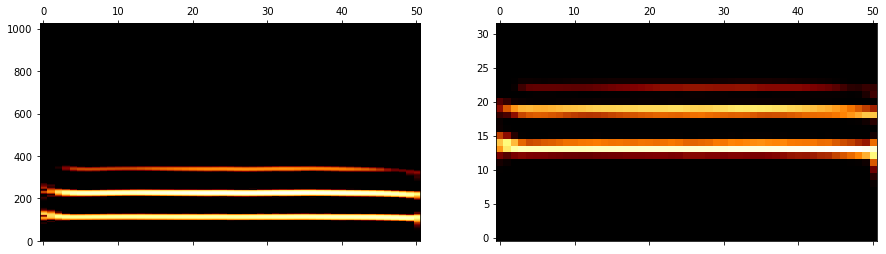

98


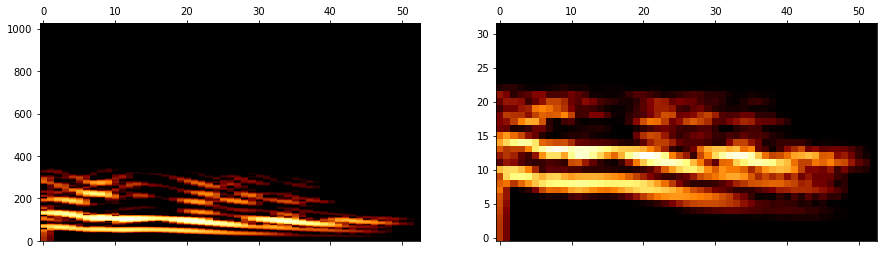

99


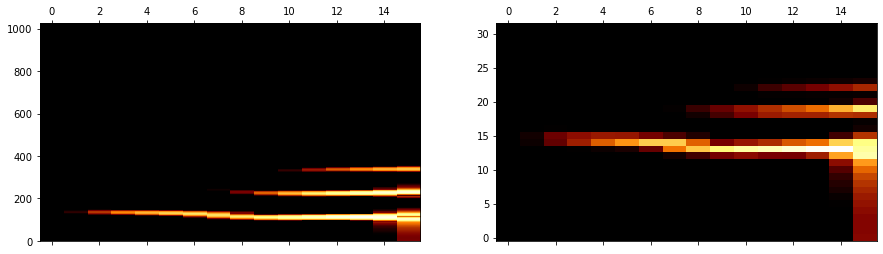

In [41]:
for i in range(100):
    print(i)
    audio = int16_to_float32(phrase_df.vocdata.values[i])
    spectrogram = sg.spectrogram(audio, rate, hparams) ##this was missing rate
    mel_spec = np.dot(spectrogram.T, mel_matrix).T
    fig, axs = plt.subplots(ncols = 2, figsize=(15,4))
    axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    #ax.axis('off')
    plt.show()